In [1]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2, os, glob

np.set_printoptions(threshold=np.inf) # NumPy 설정
os.environ["CUDA_VISIBLE_DEVICES"] = "3" # CUDA 가시성 설정 (GPU 사용시 필요)

# GPU 메모리 구성 설정 (GPU 사용시 필요)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # TensorFlow 2.x에서는 set_memory_growth 대신에 메모리 할당 옵션을 설정하는 코드
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

2024-04-03 11:23:16.431273: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-03 11:23:16.526638: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-03 11:23:18.504984: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# 뇌종양 분할( brain tumor)


- image 
  - mri는 4가지 양식(t1,t1ce,t2,flair)으로 촬영되었고, 4개를 하나의 데이터(RGB Image가 3channel인것과 같음)로 사용함
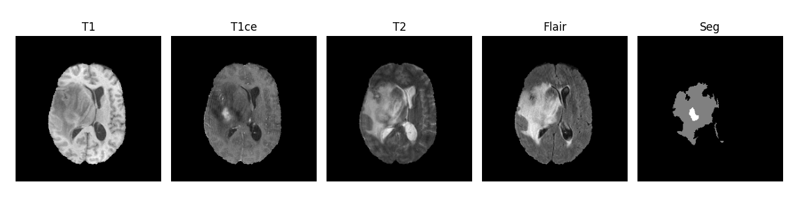

- label
  - 0 : 배경
  - 1 : 전체 종양(Whole tumor)
  - 2 : 핵심 종양(Tumor core)
  - 3 : 조영제 등으로 인해 강조된 종양(enhancing tumor)

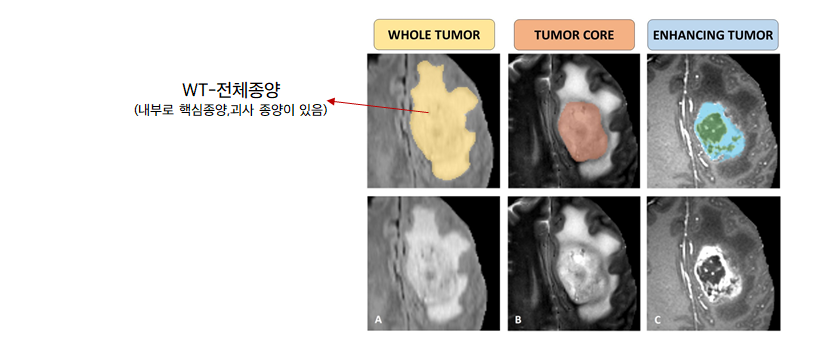

### 데이터 가져오기

In [2]:
import numpy as np
from tensorflow.keras.utils import to_categorical

# 데이터 경로 설정
train_images_path = '/home/nas/data/eunju/npy/z-score/train_images.npy'
val_images_path = '/home/nas/data/eunju/npy/z-score/val_images.npy'
test_images_path = '/home/nas/data/eunju/npy/z-score/test_images.npy'
train_labels_path = '/home/nas/data/eunju/MICCAI/non_zero/train_labels.npy'
val_labels_path = '/home/nas/data/eunju/MICCAI/non_zero/val_labels.npy'
test_labels_path = '/home/nas/data/eunju/MICCAI/non_zero/test_labels.npy'

# 데이터 로드
train_images = np.load(train_images_path)
val_images = np.load(val_images_path)
test_images = np.load(test_images_path)
train_labels = np.load(train_labels_path)
val_labels = np.load(val_labels_path)
test_labels = np.load(test_labels_path)

# 클래스 레이블 수정 (4를 3으로 대체)
train_labels = np.where(train_labels == 4, 3, train_labels)
val_labels = np.where(val_labels == 4, 3, val_labels)
test_labels = np.where(test_labels == 4, 3, test_labels)

# 클래스 레이블을 one-hot 인코딩으로 변환
num_classes = 4
train_labels = to_categorical(train_labels, num_classes=num_classes)
val_labels = to_categorical(val_labels, num_classes=num_classes)

# 데이터 차원 출력
print("train_images:", train_images.shape)
print("train_labels:", train_labels.shape)
print("val_images:", val_images.shape)
print("val_labels:", val_labels.shape)
print("test_images:", test_images.shape)
print("test_labels:", test_labels.shape)

train_images: (3906, 240, 240, 4)
train_labels: (3906, 240, 240, 4)
val_images: (1302, 240, 240, 4)
val_labels: (1302, 240, 240, 4)
test_images: (1302, 240, 240, 4)
test_labels: (1302, 240, 240)


### 데이터 확인

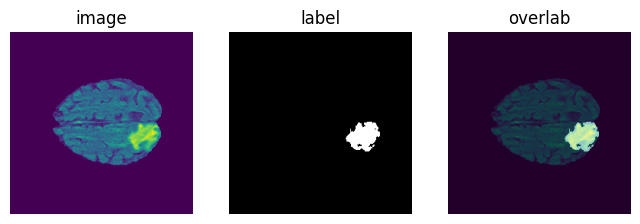

In [3]:
num = 0
plt.figure(figsize=(8,3))
plt.subplot(131); plt.imshow(test_images[num,:,:,3]);plt.title("image"); plt.axis("off")
plt.subplot(132); plt.imshow(test_labels[num,:,:], cmap='gray');plt.title("label"); plt.axis("off")

plt.subplot(133); plt.imshow(test_labels[num,:,:], cmap='gray');plt.title("overlab"); plt.axis("off")
plt.subplot(133); plt.imshow(test_images[num,:,:,3], alpha=0.5); plt.axis("off");plt.show()

### loss ( dice, bec dice loss)
- 분할에 사용할 수 있는 손실함수들 참고
- https://www.kaggle.com/code/sungjunghwan/loss-function-of-image-segmentation
- https://medium.com/@kimminha1994/loss-functions-for-semantic-segmentation-634a982de702

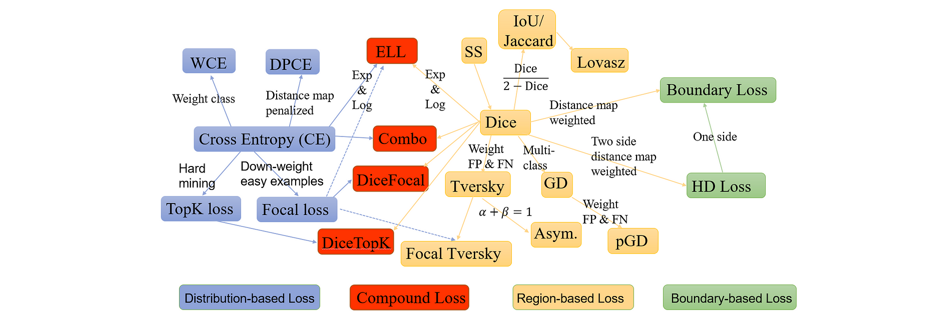

- 여기서는 dice + bce loss를 사용하였음

In [4]:
def dice_loss(y_true, y_pred):
    smooth = 1e-6
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

# Binary Crossentropy Dice Loss
def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

# ELL
def ell_loss(y_true, y_pred, alpha=0.5):
    return alpha * binary_crossentropy(y_true, y_pred) + (1 - alpha) * dice_loss(y_true, y_pred)

### 모델 평가 지표

In [5]:
def sensitivity(cm, n):  # recall, True Positive Rate
    sen = []
    for i in range(n):
        tp = cm[i][i]
        sen1 = round((tp / np.sum(cm[i, :])), 4)
        sen.append(sen1)
    return sen

class_name = ["0", "1", "2", "3"]

def specificity(cm, n): # True_negative_rate
    TNR = []
    all = np.sum(cm)
    for i in range(n):
        TP = cm[i][i]
        FP = np.sum(cm[:,i]) - TP
        FN = np.sum(cm[i,:]) - TP
        TN = all - FP - FN - TP
        tnr = round((TN/(FP+TN)),4)
        TNR.append(tnr)
    return TNR

def F1_score(cm, n):
    f1_score = []

    for i in range(n):
        TP = cm[i][i]
        FP = np.sum(cm[:,i]) - TP
        FN = np.sum(cm[i,:]) - TP
        f1score = round(((2*TP) / (2*TP+FP+FN)),4)
        f1_score.append(f1score)
    return f1_score

def precision(cm, n): # Ppv
    positive_predictive_value = []
    
    for i in range(n):
        TP = cm[i][i]
        TP_FP = np.sum(cm[:,i])
        ppv = round((TP/TP_FP), 4)
        positive_predictive_value.append(ppv)
    return positive_predictive_value

### 시각화

In [6]:
def visual_num(n) :
    num =n
    test_image = test_images[num]
    test_label = test_labels[num]
    prediction = model.predict(np.expand_dims(test_image, axis=0))[0]
    prediction = np.argmax(prediction, axis=-1)
# 예측 결과 시각화
    plt.figure(figsize=(9,5))
    plt.subplot(241) ;  plt.imshow(test_image[:,:,0], cmap='gray') ; plt.title('T1');plt.axis('off')
    plt.subplot(242) ;  plt.imshow(test_image[:,:,1], cmap='gray') ; plt.title('T1ce'); plt.axis('off')
    plt.subplot(243) ;  plt.imshow(test_image[:,:,2], cmap='gray') ; plt.title('T2'); plt.axis('off')
    plt.subplot(244) ;  plt.imshow(test_image[:,:,3], cmap='gray') ; plt.title('flair'); plt.axis('off')
    t1 = np.where(test_label == 0, 1,0).astype('uint8')
    t2 = np.where(test_label == 1, 1,0).astype('uint8')
    t3 = np.where(test_label == 2, 1,0).astype('uint8')
    t4 = np.where(test_label == 3, 1,0).astype('uint8')
    plt.subplot(245); plt.imshow(test_label, cmap='gray'); plt.title('Ground Truth');plt.axis('off')
    plt.subplot(2,4,6) ; plt.imshow(prediction, cmap='gray'); plt.title('Predicted');plt.axis('off')
    plt.subplot(2,4,7) ; plt.imshow(abs(test_label-prediction), cmap='gray'); plt.title('GT - pred');plt.axis('off')
    plt.subplot(2,4,8) ; plt.imshow(test_image[:,:,3], cmap='gray'); plt.title('flair overlab');plt.axis('off')
    plt.subplot(2,4,8) ; plt.imshow(abs(test_label-prediction), cmap='jet',alpha=0.5);plt.axis('off')
    t = test_label.flatten()
    p = prediction.flatten()
    matches = t == p
    num_mismatches = len(matches) - np.count_nonzero(matches)
    mismatch_indices = np.where(matches == False)[0]
    print("mismatched labels:", num_mismatches)
    plt.tight_layout();plt.show()

<br>

----

<br>

### 모델 구조
- 구조는 u-net, inception, FPN, Dilated Convolution 등 다양하게 시도해볼 수 있음

In [7]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import tensorflow as tf
import tensorflow.keras.layers as L

def conv_block(x, num_filters, act=True):
    x = L.Conv2D(num_filters, kernel_size=3, padding="same")(x)

    if act == True:
        x = L.BatchNormalization()(x)
        x = L.Activation("relu")(x)

    return x

def encoder_block(x, num_filters):
    x = conv_block(x, num_filters)
    x = conv_block(x, num_filters)

    p = L.MaxPool2D((2, 2))(x)
    return x, p

def unet3plus(input_shape, num_classes=1, deep_sup=True):
    """ Inputs """
    inputs = L.Input(input_shape, name="input_layer") ## (256 x 256 x 3)

    """ Encoder """
    e1, p1 = encoder_block(inputs, 64)
    e2, p2 = encoder_block(p1, 128)
    e3, p3 = encoder_block(p2, 256)
    e4, p4 = encoder_block(p3, 512)
    # print(e1.shape, e2.shape, e3.shape, e4.shape)

    """ Bottleneck """
    e5 = conv_block(p4, 1024)
    e5 = conv_block(e5, 1024)

    """ Decoder 4 """
    e1_d4 = L.MaxPool2D((8, 8))(e1)
    e1_d4 = conv_block(e1_d4, 64)

    e2_d4 = L.MaxPool2D((4, 4))(e2)
    e2_d4 = conv_block(e2_d4, 64)

    e3_d4 = L.MaxPool2D((2, 2))(e3)
    e3_d4 = conv_block(e3_d4, 64)

    e4_d4 = conv_block(e4, 64)

    e5_d4 = L.UpSampling2D((2, 2), interpolation="bilinear")(e5)
    e5_d4 = conv_block(e5_d4, 64)

    d4 = L.Concatenate()([e1_d4, e2_d4, e3_d4, e4_d4, e5_d4])
    d4 = conv_block(d4, 64*5)

    """ Decoder 3 """
    e1_d3 = L.MaxPool2D((4, 4))(e1)
    e1_d3 = conv_block(e1_d3, 64)

    e2_d3 = L.MaxPool2D((2, 2))(e2)
    e2_d3 = conv_block(e2_d3, 64)

    e3_d3 = conv_block(e3, 64)

    d4_d3 = L.UpSampling2D((2, 2), interpolation="bilinear")(d4)
    d4_d3 = conv_block(d4_d3, 64)

    e5_d3 = L.UpSampling2D((4, 4), interpolation="bilinear")(e5)
    e5_d3 = conv_block(e5_d3, 64)

    d3 = L.Concatenate()([e1_d3, e2_d3, e3_d3, d4_d3, e5_d3])
    d3 = conv_block(d3, 64*5)

    """ Decoder 2 """
    e1_d2 = L.MaxPool2D((2, 2))(e1)
    e1_d2 = conv_block(e1_d2, 64)

    e2_d2 = conv_block(e2, 64)

    d3_d2 = L.UpSampling2D((2, 2), interpolation="bilinear")(d3)
    d3_d2 = conv_block(d3_d2, 64)

    d4_d2 = L.UpSampling2D((4, 4), interpolation="bilinear")(d4)
    d4_d2 = conv_block(d4_d2, 64)

    e5_d2 = L.UpSampling2D((8, 8), interpolation="bilinear")(e5)
    e5_d2 = conv_block(e5_d2, 64)

    d2 = L.Concatenate()([e1_d2, e2_d2, d3_d2, d4_d2, e5_d2])
    d2 = conv_block(d2, 64*5)

    """ Decoder 1 """
    e1_d1 = conv_block(e1, 64)

    d2_d1 = L.UpSampling2D((2, 2), interpolation="bilinear")(d2)
    d2_d1 = conv_block(d2_d1, 64)

    d3_d1 = L.UpSampling2D((4, 4), interpolation="bilinear")(d3)
    d3_d1 = conv_block(d3_d1, 64)

    d4_d1 = L.UpSampling2D((8, 8), interpolation="bilinear")(d4)
    d4_d1 = conv_block(d4_d1, 64)

    e5_d1 = L.UpSampling2D((16, 16), interpolation="bilinear")(e5)
    e5_d1 = conv_block(e5_d1, 64)

    d1 = L.Concatenate()([e1_d1, d2_d1, d3_d1, d4_d1, e5_d1])
    d1 = conv_block(d1, 64*5)

    """ Deep Supervision """
    if deep_sup == True:
        y1 = L.Conv2D(num_classes, kernel_size=1, padding="same")(d1)
        y1 = L.Activation("sigmoid")(y1)

        y2 = L.Conv2D(num_classes, kernel_size=1, padding="same")(d2)
        y2 = L.UpSampling2D((2, 2), interpolation="bilinear")(y2)
        y2 = L.Activation("sigmoid")(y2)

        y3 = L.Conv2D(num_classes, kernel_size=1, padding="same")(d3)
        y3 = L.UpSampling2D((4, 4), interpolation="bilinear")(y3)
        y3 = L.Activation("sigmoid")(y3)

        y4 = L.Conv2D(num_classes, kernel_size=1, padding="same")(d4)
        y4 = L.UpSampling2D((8, 8), interpolation="bilinear")(y4)
        y4 = L.Activation("sigmoid")(y4)

        y5 = L.Conv2D(num_classes, kernel_size=1, padding="same")(e5)
        y5 = L.UpSampling2D((16, 16), interpolation="bilinear")(y5)
        y5 = L.Activation("sigmoid")(y5)

        outputs = [y1, y2, y3, y4, y5]

    else:
        y1 = L.Conv2D(num_classes, kernel_size=1, padding="same")(d1)
        y1 = L.Activation("sigmoid")(y1)
        outputs = [y1]

    model = tf.keras.Model(inputs, outputs)
    return model


if __name__ == "__main__":
    input_shape = (240, 240, 4)
    model = unet3plus(input_shape, num_classes=4, deep_sup=False)
    model.summary()

2024-04-03 11:23:50.157807: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 37593 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:af:00.0, compute capability: 8.0


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 240, 240, 4)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 240, 240, 64)         2368      ['input_layer[0][0]']         
                                                                                                  
 batch_normalization (Batch  (None, 240, 240, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 240, 240, 64)         0         ['batch_normalization[0][0

In [8]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K

model.compile(optimizer='adam', loss=bce_dice_loss, metrics=['accuracy'])

# 커널이 죽는다면 batch_size를 줄이면 됨
history= model.fit(train_images, train_labels, epochs=100, batch_size=8, validation_data=(val_images, val_labels))

Epoch 1/100


2024-04-03 11:24:35.686756: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-04-03 11:24:37.019488: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-03 11:24:42.751589: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7eef66426080 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-03 11:24:42.751683: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
2024-04-03 11:24:42.761956: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-03 11:24:42.925870: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-03 11:24:43.039881: I ./tensorflow/compiler/jit/device_compil

489/489 [==============================] - ETA: 0s - loss: 0.0586 - accuracy: 0.9855

2024-04-03 11:27:53.105823: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


489/489 [==============================] - 242s 352ms/step - loss: 0.0586 - accuracy: 0.9855 - val_loss: 0.0601 - val_accuracy: 0.9776
Epoch 2/100
489/489 [==============================] - 131s 268ms/step - loss: 0.0220 - accuracy: 0.9920 - val_loss: 0.0235 - val_accuracy: 0.9918
Epoch 3/100
489/489 [==============================] - 132s 270ms/step - loss: 0.0185 - accuracy: 0.9931 - val_loss: 0.0249 - val_accuracy: 0.9907
Epoch 4/100
489/489 [==============================] - 131s 268ms/step - loss: 0.0166 - accuracy: 0.9938 - val_loss: 0.0165 - val_accuracy: 0.9939
Epoch 5/100
489/489 [==============================] - 130s 266ms/step - loss: 0.0153 - accuracy: 0.9942 - val_loss: 0.0165 - val_accuracy: 0.9938
Epoch 6/100
489/489 [==============================] - 131s 268ms/step - loss: 0.0149 - accuracy: 0.9944 - val_loss: 0.0197 - val_accuracy: 0.9927
Epoch 7/100
489/489 [==============================] - 131s 267ms/step - loss: 0.0135 - accuracy: 0.9948 - val_loss: 0.0127 - val_

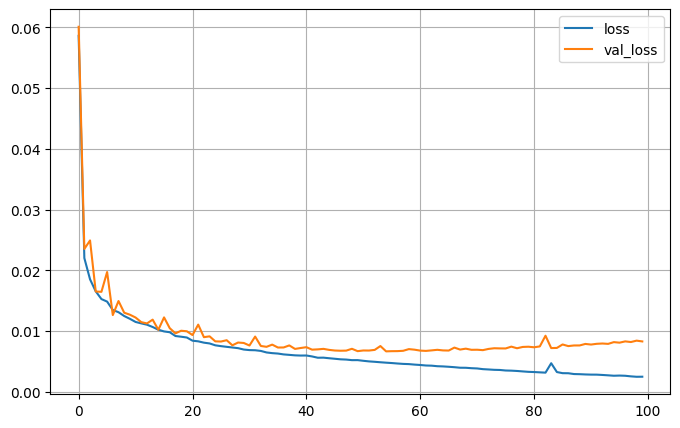

(<matplotlib.legend.Legend at 0x7efad0b24490>, None, None)

In [9]:
plot_target = ['loss', 'val_loss']
plt.figure(figsize=(8,5))
for each in plot_target:
    plt.plot(history.history[each], label = each)
plt.legend(), plt.grid(), plt.show()

#### test data evaluate

In [11]:
test_label_e = to_categorical(test_labels, num_classes=4)
loss, acc = model.evaluate(test_images, test_label_e, verbose=2)

41/41 - 10s - loss: 0.0084 - accuracy: 0.9974 - 10s/epoch - 249ms/step


In [12]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(test_images)

y_true = np.argmax(test_label_e, axis=3)
y_pred = np.argmax(y_pred, axis=3)

y_true_flat = y_true.flatten()
y_pred_flat = y_pred.flatten()

conf_mat = confusion_matrix(y_true_flat, y_pred_flat)

41/41 [==============================] - 11s 241ms/step


In [13]:
import pandas as pd

Sensitivity = sensitivity(conf_mat, 4)
Specificity = specificity(conf_mat, 4)
f1 = F1_score(conf_mat, 4)
Positive_predictive_value = precision(conf_mat, 4)

data = {'Sensitivity': Sensitivity,
        'Specificity': Specificity,
        'F1 Score': f1,
        'Precision': Positive_predictive_value}

df = pd.DataFrame(data, index=class_name)
df.loc['Col Ave'] = df.mean()

df

,Sensitivity,Specificity,F1 Score,Precision
0,0.999100,0.95390,0.999000,0.9990
1,0.890400,0.99970,0.892000,0.8936
2,0.928900,0.99900,0.928800,0.9288
3,0.898300,0.99960,0.901300,0.9042
Col Ave,0.929175,0.98805,0.930275,0.9314


### 결과 확인
- 정답값과 예측값을 비교해보면 결과가 좋음
- 차이를 확인해보면 대부분 경계에서 오류가 있는 걸 알 수 있음
- 경계값을 잘 맞추도록 수정하면 더 좋은 결과를 얻을 수 있을 것으로 생각됨

1 )
1/1 [==============================] - 2s 2s/step
mismatched labels: 103


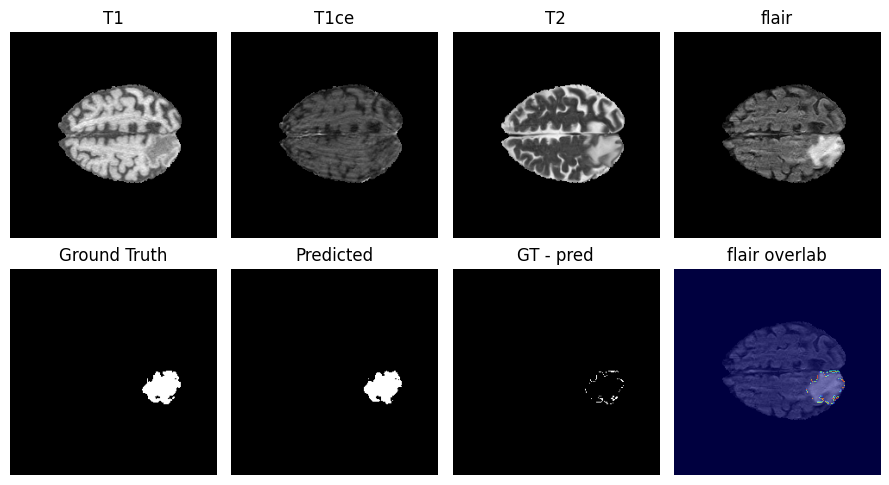

2 )
1/1 [==============================] - 0s 74ms/step
mismatched labels: 131


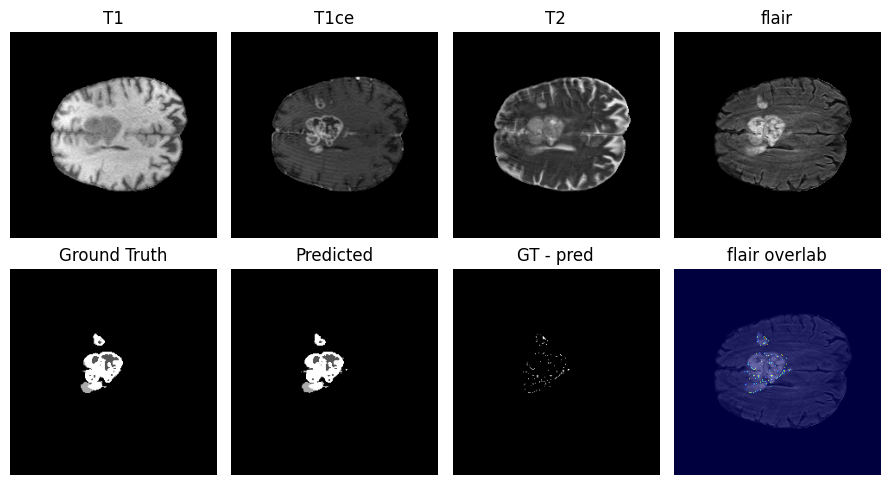

3 )
1/1 [==============================] - 0s 60ms/step
mismatched labels: 226


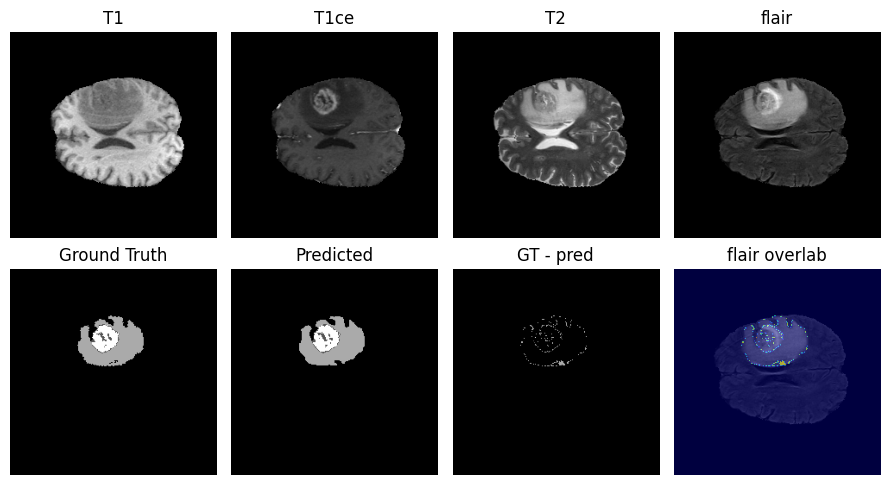

4 )
1/1 [==============================] - 0s 53ms/step
mismatched labels: 35


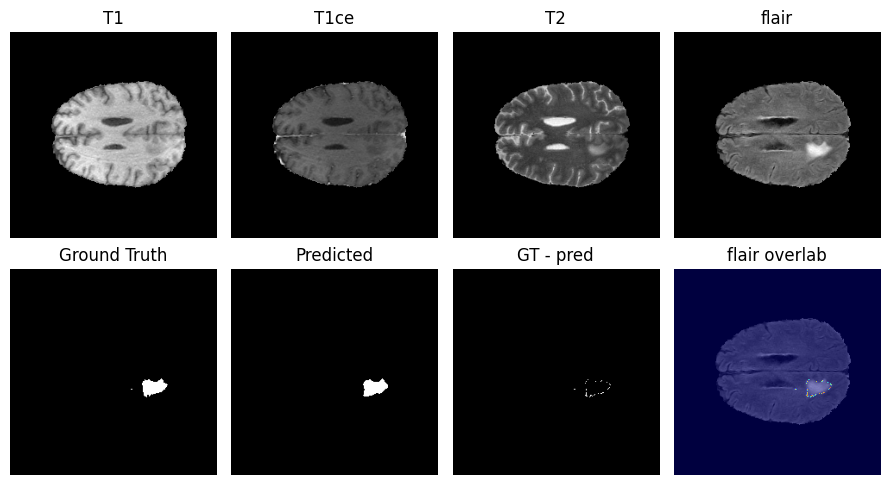

5 )
1/1 [==============================] - 0s 52ms/step
mismatched labels: 185


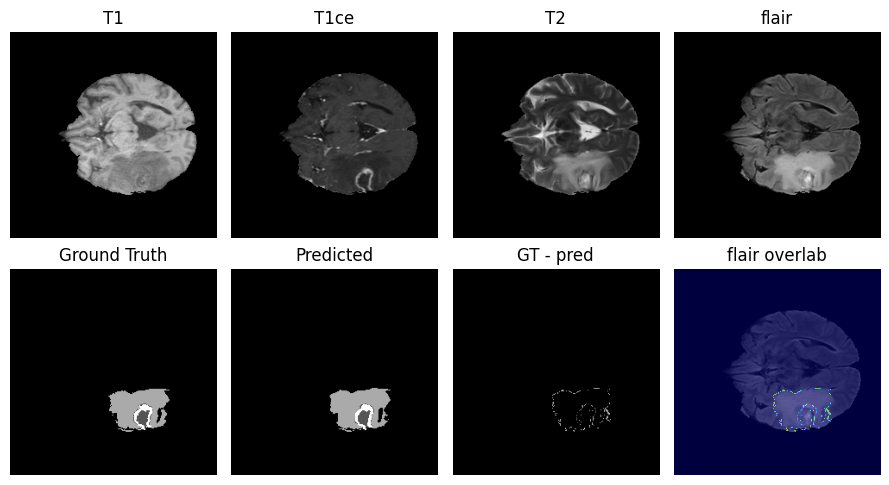

In [14]:
for i in range(5) :
    print(i+1,")")
    visual_num(i)

### 모델 저장

In [31]:
#model.save('../model(1).h5')

<br><br><Br>